<a href="https://colab.research.google.com/github/Jorgellamocca/GitC3Swrf/blob/main/ECMWF_PERU_anomPrecTmaxTmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Las siguientes gráficas corresponden a la base de datos de Copernicus en su versión actualizada, la cual permite mostrar el **pronóstico de los modelos globales** a nivel mensual para la anomalía de la **Temperatura máxima, mínima y precipitación**.  
Consultas: smn@senamhi.gob.pe



In [ ]:
##MAPA NACIONAL DE LA ANOMALIA DE LA PRECIPTACION

In [1]:
# Instalar librerías necesarias
!pip install xarray cartopy matplotlib pandas scipy geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 36.2 MB/s eta 0:00:00


Archivo descargado exitosamente: departamentos.shp
Archivo descargado exitosamente: departamentos.dbf
Archivo descargado exitosamente: departamentos.shx
Archivo descargado exitosamente: flx.anom.ecmwf.nc


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


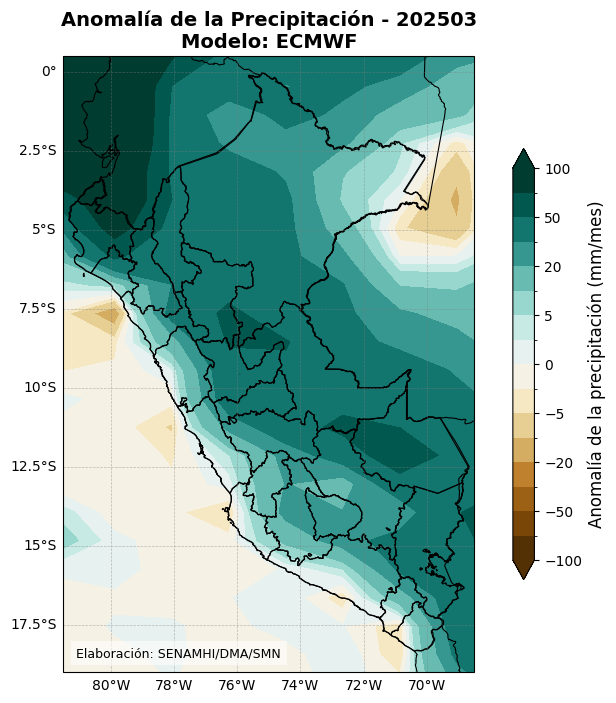

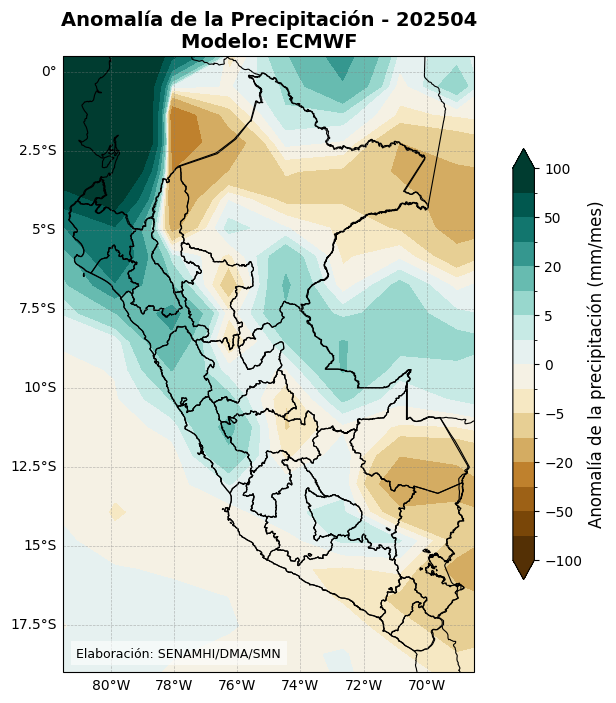

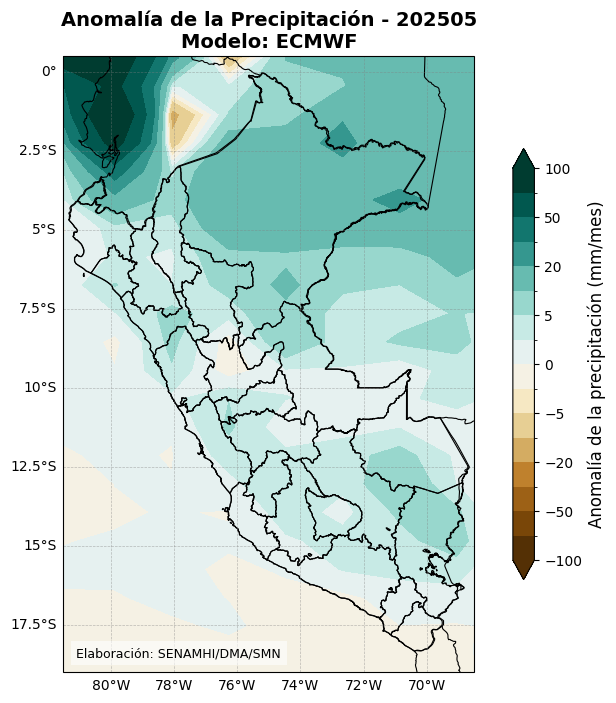

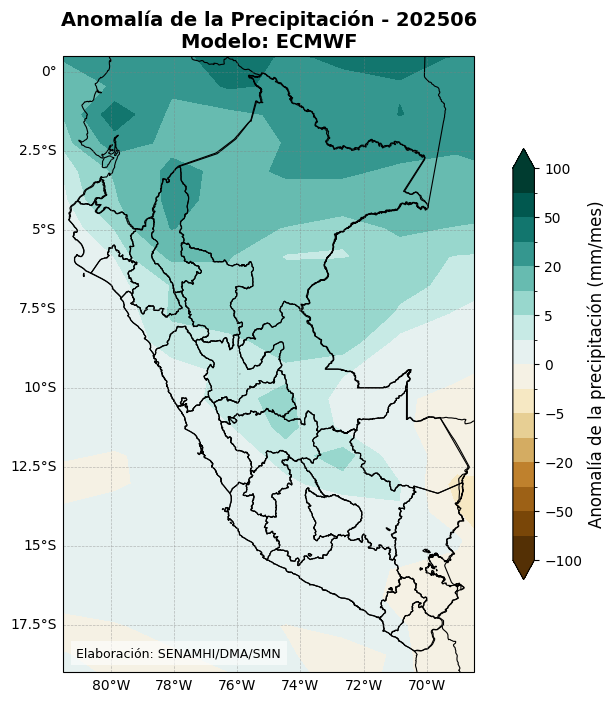

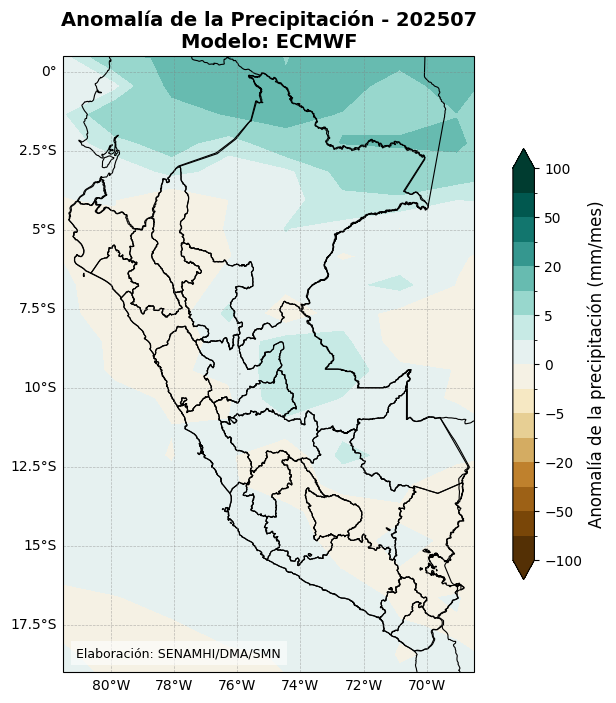

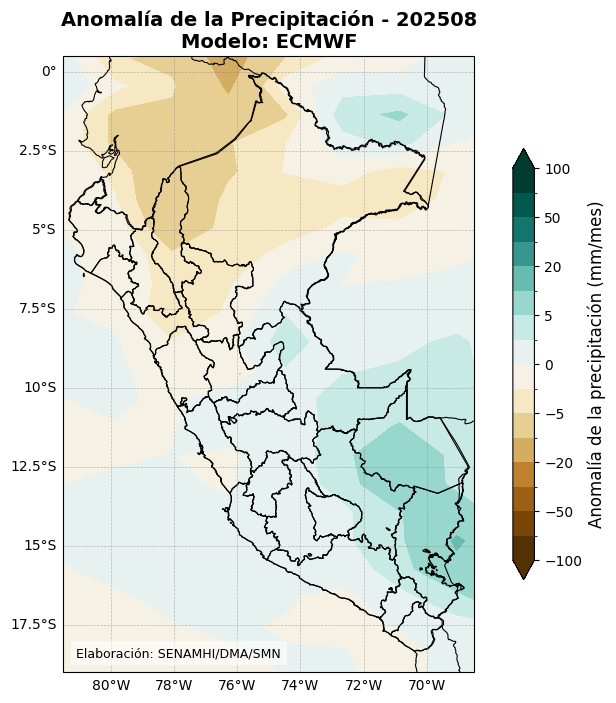

In [2]:
# Instalar librerías necesarias
#!pip install xarray cartopy matplotlib pandas scipy geopandas

import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import BoundaryNorm
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import geopandas as gpd

# Función para descargar archivos desde una URL
def download_file(url, local_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(response.content)
            print(f"Archivo descargado exitosamente: {local_path}")
        else:
            print(f"Error al descargar el archivo: {response.status_code}")
    except Exception as e:
        print(f"Error durante la descarga: {e}")

# Descargar archivos de datos y shapefiles
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",
}

for name, url in shapefiles.items():
    download_file(url, name)

# Configurar el directorio de salida
output_dir = '/content/graphics'
os.makedirs(output_dir, exist_ok=True)

# Descargar archivo NetCDF desde GitHub
data_url = "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data/flx.anom.ecmwf.nc"
local_data_file = "flx.anom.ecmwf.nc"
download_file(data_url, local_data_file)

# Configurar extensión del mapa
extent = [-81.5, -68.5, -19, 0.5]

# Cargar dataset ECMWF
ecmwf_ds = xr.open_dataset(local_data_file)
ref_time_ecmwf = ecmwf_ds['forecast_reference_time'].values[0]

# Definir función para interpolación cúbica
def cubic_interpolation(variable, lon, lat, new_lon, new_lat):
    lon2d, lat2d = np.meshgrid(lon, lat)
    points = np.array([lon2d.flatten(), lat2d.flatten()]).T
    values = variable.values.flatten()

    new_lon2d, new_lat2d = np.meshgrid(new_lon, new_lat)
    new_points = np.array([new_lon2d.flatten(), new_lat2d.flatten()]).T

    interpolated_values = griddata(points, values, new_points, method='cubic')
    return interpolated_values.reshape(new_lon2d.shape)

# Definir función para graficar variable
def plot_variable(variable, variable_name, cmap, bounds, norm, title_prefix, output_dir, filename_suffix, colorbar_label, modelo, ref_time, gdf_departamentos):
    for fm in range(1, 7):
        if 'forecastMonth' in variable.coords:
            variable_fm = variable.sel(forecastMonth=fm)
        else:
            continue

        forecast_date = pd.to_datetime(ref_time) + pd.DateOffset(months=fm - 1)
        date_str = forecast_date.strftime('%Y%m')

        lon = variable_fm['longitude'].values
        lat = variable_fm['latitude'].values

        new_lon = np.linspace(lon.min(), lon.max(), 200)
        new_lat = np.linspace(lat.min(), lat.max(), 200)

        interpolated_values = cubic_interpolation(variable_fm, lon, lat, new_lon, new_lat)

        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

        if not np.isnan(interpolated_values).all():
            plot = ax.contourf(new_lon, new_lat, interpolated_values, levels=bounds, cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

            # Añadir límites de los departamentos de Perú (usando GeoPandas)
            gdf_departamentos.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, transform=ccrs.PlateCarree())

            ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.8)
            ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
            ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none', linewidth=0.6)

            ax.set_title(f'{title_prefix} - {date_str}\nModelo: {modelo.upper()}', fontsize=14, fontweight='bold')

            ax.set_extent(extent)

            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.xlocator = mticker.MultipleLocator(2)
            gl.ylocator = mticker.MultipleLocator(2.5)
            gl.top_labels = False
            gl.right_labels = False

            cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.7)
            cbar.set_label(colorbar_label, fontsize=12)

            ax.text(0.53, 0.02, 'Elaboración: SENAMHI/DMA/SMN',
                    horizontalalignment='right', verticalalignment='bottom',
                    transform=ax.transAxes, fontsize=9, color='black',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            filename = f'pre_{modelo}_{date_str}_{filename_suffix}_per.png'
            plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
            plt.show()

        else:
            ax.set_title(f'Datos no disponibles - {date_str}')
            ax.set_extent(extent)
            plt.show()

        plt.close()

# Cargar shapefile de departamentos
gdf_departamentos = gpd.read_file("departamentos.shp")

# Lista de modelos a procesar
modelos = ['ecmwf']

# Configurar información de las variables
variables_info = {
    'mx2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmax',
        'filename_suffix': 'anomTempMax',
        'colorbar_label': 'Anomalía de la Tmax (°C)'
    },
    'mn2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmin',
        'filename_suffix': 'anomTempMin',
        'colorbar_label': 'Anomalía de la Tmin (°C)'
    },
    'tpara': {
        'cmap': 'BrBG',
        'bounds': np.array([-100, -80, -50, -30, -20, -10, -5, -2.5, 0, 2.5, 5, 10, 20, 30, 50, 80, 100]),
        'title_prefix': 'Anomalía de la Precipitación',
        'filename_suffix': 'anomPrec',
        'colorbar_label': 'Anomalía de la precipitación (mm/mes)'
    }
}

# Procesar cada modelo
for modelo in modelos:
    ds = xr.open_dataset(local_data_file)

    # Convertir precipitación acumulada si está presente
    if 'tpara' in ds:
        segundos_por_mes = 30 * 24 * 3600
        ds['tpara'] = ds['tpara'] * 1000 * segundos_por_mes

    ref_time = ref_time_ecmwf

    for var, info in variables_info.items():
        if var in ds:
            variable = ds[var]
            norm = BoundaryNorm(boundaries=info['bounds'], ncolors=256)
            plot_variable(variable, var, info['cmap'], info['bounds'], norm, info['title_prefix'], output_dir, info['filename_suffix'], info['colorbar_label'], modelo, ref_time, gdf_departamentos)
